# Imports

[](http://)

In [ ]:
# ---------------------------- Model Definition ---------------------------- #

model = Sequential()
model.add(Conv2D(32, kernel_size=(5, 5), padding='Same', activation='relu', input_shape=(img_size, img_size, 1)))
model.add(Conv2D(32, kernel_size=(5, 5), padding='Same', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size=(3, 3), padding='Same', activation='relu'))
model.add(Conv2D(64, kernel_size=(3, 3), padding='Same', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

In [ ]:
# ---------------------------- Callbacks ---------------------------- #

callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=10, verbose=1, restore_best_weights=True),
    ModelCheckpoint("finger_model.h5", monitor='val_accuracy', save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.00001, verbose=1)
]

# ---------------------------- Model Training ---------------------------- #

history = model.fit(X_train, y_train, batch_size=86, epochs=30, validation_data=(X_val, y_val), verbose=1, callbacks=callbacks)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ----------------- Evaluate on Training and Validation ----------------- #
train_loss, train_acc = model.evaluate(X_train, y_train, verbose=0)
val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)

print(f"Training Accuracy: {train_acc*100:.2f}%")
print(f"Validation Accuracy: {val_acc*100:.2f}%")

# ----------------- Evaluate on Test Data ----------------- #
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_acc*100:.2f}%")

# ----------------- Confusion Matrix ----------------- #
# Predict classes
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)  # If y_test is one-hot encoded

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

# ----------------- Plot Confusion Matrix ----------------- #
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# ----------------- Optional: Classification Report ----------------- #
print("\nClassification Report:")
print(classification_report(y_true, y_pred))


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
# Extract accuracy and loss values
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
# Plot training and validation accuracy
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
# Plot training and validation loss
plt.figure()
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

In [ ]:
model.save("Finger+gender_model_02.h5")

In [ ]:
import numpy as np
import cv2
import json
from tensorflow.keras.models import load_model

# ---------------------------- Configuration ---------------------------- #

img_size = 96
model_path = '/kaggle/working/Finger+gender_model_02.h5'  # Ensure this file is available in the working directory

# Label mapping from your print output
label_to_index = {
    'Female_Left_index': 0, 'Female_Left_little': 1, 'Female_Left_middle': 2, 'Female_Left_ring': 3, 'Female_Left_thumb': 4,
    'Female_Right_index': 5, 'Female_Right_little': 6, 'Female_Right_middle': 7, 'Female_Right_ring': 8, 'Female_Right_thumb': 9,
    'Male_Left_index': 10, 'Male_Left_little': 11, 'Male_Left_middle': 12, 'Male_Left_ring': 13, 'Male_Left_thumb': 14,
    'Male_Right_index': 15, 'Male_Right_little': 16, 'Male_Right_middle': 17, 'Male_Right_ring': 18, 'Male_Right_thumb': 19
}
index_to_label = {idx: label for label, idx in label_to_index.items()}

# ---------------------------- Prediction Function ---------------------------- #

def predict_finger_type(img_path):
    model = load_model(model_path)

    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"Image not found or cannot be read: {img_path}")

    img_resized = cv2.resize(img, (img_size, img_size))
    img_normalized = img_resized / 255.0
    img_input = img_normalized.reshape(1, img_size, img_size, 1)

    pred_probs = model.predict(img_input, verbose=0)[0]
    pred_class = np.argmax(pred_probs)
    combined_label = index_to_label[pred_class]

    print(f"Predicted Finger Type: {combined_label}")
    print(f"Confidence: {pred_probs[pred_class]*100:.2f}%")

    return combined_label, pred_probs[pred_class]

# ---------------------------- Example Usage ---------------------------- #

# Replace these paths with the actual paths to your images
test_image_path1 = '/kaggle/input/socofing/SOCOFing/Real/100__M_Left_index_finger.BMP'
test_image_path2 = '/kaggle/input/socofing/SOCOFing/Altered/Altered-Medium/103__F_Left_ring_finger_Obl.BMP'
test_image_path3 = '/kaggle/input/socofing/SOCOFing/Altered/Altered-Easy/100__M_Left_index_finger_CR.BMP'

# Predict finger type
predict_finger_type(test_image_path1)
predict_finger_type(test_image_path2)
predict_finger_type(test_image_path3)

In [1]:
# Install TensorFlow Addons if you want rotation augmentation
# !pip install -q tensorflow-addons

import os, random
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint


In [2]:
import os, shutil
from tqdm import tqdm

# Input folders
BASE_DIR = "/kaggle/input/socofing/SOCOFing"
source_folders = [
    os.path.join(BASE_DIR, "Real"),
    os.path.join(BASE_DIR, "Altered/Altered-Easy"),
    os.path.join(BASE_DIR, "Altered/Altered-Medium"),
    os.path.join(BASE_DIR, "Altered/Altered-Hard")
]

# Output folder (20 combined classes)
OUTPUT_DIR = "/kaggle/working/socofing_20class"
os.makedirs(OUTPUT_DIR, exist_ok=True)

def parse_filename(fname):
    """Extract gender + hand + finger from SOCOFing filename"""
    parts = fname.split("__")
    if len(parts) < 2:
        return None
    gender_token = parts[1][0]  # M or F
    gender = "Male" if gender_token == "M" else "Female"
    tokens = parts[1].split("_")
    if len(tokens) < 3:
        return None
    hand = tokens[1].capitalize()   # Left / Right
    finger = tokens[2].capitalize() # Thumb/Index/Middle/Ring/Little
    label = f"{gender}_{hand}_{finger}"
    return label

# Organize into folders
for folder in source_folders:
    for fname in tqdm(os.listdir(folder), desc=f"Processing {os.path.basename(folder)}"):
        if not fname.lower().endswith(".bmp"):
            continue
        label = parse_filename(fname)
        if label is None:
            continue
        dest_dir = os.path.join(OUTPUT_DIR, label)
        os.makedirs(dest_dir, exist_ok=True)
        shutil.copy(os.path.join(folder, fname), os.path.join(dest_dir, fname))

print("✅ Dataset organized into 20 classes at:", OUTPUT_DIR)


Processing Altered-Hard: 100%|██████████| 14272/14272 [02:16<00:00, 106.35it/s]

✅ Dataset organized into 20 classes at: /kaggle/working/socofing_20class


In [4]:
import os, random
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint


In [6]:
# Base directory where you created the 20 classes
BASE_DIR = "/kaggle/working/socofing_20class"

IMG_SIZE = 160
BATCH_SIZE = 32
SEED = 42
EPOCHS = 30
SPLIT = (0.8, 0.1, 0.1)  # subject-wise split

AUTOTUNE = tf.data.experimental.AUTOTUNE



In [7]:
subj_map = defaultdict(list)
classes_set = set()

for cls in os.listdir(BASE_DIR):
    cls_dir = os.path.join(BASE_DIR, cls)
    for fname in os.listdir(cls_dir):
        if not fname.lower().endswith(".bmp"):
            continue
        subject = fname.split("__")[0]   # subject ID
        label = cls
        subj_map[subject].append((os.path.join(cls_dir, fname), label))
        classes_set.add(label)

classes = sorted(list(classes_set))
num_classes = len(classes)
print("Classes:", num_classes, classes)


Classes: 20 ['Female_Left_Index', 'Female_Left_Little', 'Female_Left_Middle', 'Female_Left_Ring', 'Female_Left_Thumb', 'Female_Right_Index', 'Female_Right_Little', 'Female_Right_Middle', 'Female_Right_Ring', 'Female_Right_Thumb', 'Male_Left_Index', 'Male_Left_Little', 'Male_Left_Middle', 'Male_Left_Ring', 'Male_Left_Thumb', 'Male_Right_Index', 'Male_Right_Little', 'Male_Right_Middle', 'Male_Right_Ring', 'Male_Right_Thumb']


In [8]:
random.seed(SEED)
subjects = list(subj_map.keys())
random.shuffle(subjects)

n = len(subjects)
n_train = int(n * SPLIT[0])
n_val = int(n * SPLIT[1])

train_subj = subjects[:n_train]
val_subj = subjects[n_train:n_train+n_val]
test_subj = subjects[n_train+n_val:]

def build_file_list(subj_list):
    files, labels = [], []
    for s in subj_list:
        for fp, lab in subj_map[s]:
            files.append(fp)
            labels.append(lab)
    return files, labels

train_files, train_labels = build_file_list(train_subj)
val_files, val_labels = build_file_list(val_subj)
test_files, test_labels = build_file_list(test_subj)

print("Train:", len(train_files), "Val:", len(val_files), "Test:", len(test_files))


Train: 19170 Val: 2388 Test: 2395


In [9]:
label_to_index = {lab:i for i,lab in enumerate(classes)}
index_to_label = {i:lab for lab,i in label_to_index.items()}

train_y = np.array([label_to_index[l] for l in train_labels])
val_y = np.array([label_to_index[l] for l in val_labels])
test_y = np.array([label_to_index[l] for l in test_labels])


In [24]:
from PIL import Image
import numpy as np

def read_image(path):
    """Load image with PIL and return RGB normalized array"""
    path = path.decode("utf-8")  # TensorFlow -> string
    img = Image.open(path).convert("RGB")  # force RGB
    img = img.resize((IMG_SIZE, IMG_SIZE))
    img = np.array(img).astype(np.float32) / 255.0
    return img

def decode_and_resize(path, label):
    image = tf.numpy_function(read_image, [path], tf.float32)
    image.set_shape([IMG_SIZE, IMG_SIZE, 3])  # important for TF graph
    return image, label

def make_dataset(files, labels, shuffle=False, augment=False):
    ds = tf.data.Dataset.from_tensor_slices((files, labels))
    ds = ds.map(decode_and_resize, num_parallel_calls=AUTOTUNE)

    if shuffle:
        ds = ds.shuffle(2000, seed=SEED)

    if augment:
        ds = ds.map(lambda x,y: (tf.image.random_flip_left_right(x), y), AUTOTUNE)
        ds = ds.map(lambda x,y: (tf.image.random_brightness(x,0.1), y), AUTOTUNE)
        ds = ds.map(lambda x,y: (tf.image.random_contrast(x,0.9,1.1), y), AUTOTUNE)

    return ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)

# ✅ Rebuild datasets with PIL loader
train_ds = make_dataset(train_files, train_y, shuffle=True, augment=True)
val_ds   = make_dataset(val_files, val_y)
test_ds  = make_dataset(test_files, test_y)


In [12]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models

# Build MobileNetV2 from scratch (no ImageNet weights to avoid download)
base = MobileNetV2(include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3), weights=None)
base.trainable = True  # since no pretrained weights, we train all layers

inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = base(inputs, training=True)   # allow training since no pretrained
x = layers.BatchNormalization()(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model = models.Model(inputs, outputs)

# Compile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_160 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
batch_normalization (BatchNo (None, 5, 5, 1280)        5120      
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               327936    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dropout (Dropout)            (None, 256)               0     

In [13]:
callbacks = [
    EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6, verbose=1),
    ModelCheckpoint("best_model.h5", monitor="val_accuracy", save_best_only=True, verbose=1)
]


In [26]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/30
600/600 [==============================] - 82s 137ms/step - loss: 2.9034 - acc: 0.1854 - val_loss: 2.3587 - val_acc: 0.2630
Epoch 2/30
600/600 [==============================] - 76s 127ms/step - loss: 2.7160 - acc: 0.2140 - val_loss: 2.2480 - val_acc: 0.2982
Epoch 3/30
600/600 [==============================] - 76s 127ms/step - loss: 2.5451 - acc: 0.2433 - val_loss: 2.1661 - val_acc: 0.3354
Epoch 4/30
600/600 [==============================] - 76s 126ms/step - loss: 2.4326 - acc: 0.2619 - val_loss: 2.0889 - val_acc: 0.3668
Epoch 5/30
600/600 [==============================] - 76s 127ms/step - loss: 2.2758 - acc: 0.2990 - val_loss: 2.0266 - val_acc: 0.3727
Epoch 6/30
600/600 [==============================] - 76s 127ms/step - loss: 2.1267 - acc: 0.3385 - val_loss: 1.9532 - val_acc: 0.3957
Epoch 7/30
600/600 [==============================] - 76s 127ms/step - loss: 1.9569 - acc: 0.3817 - val_loss: 1.8292 - val_acc: 0.4250
Epoch 8/30
600/600 [==============================] - 7

In [27]:
base.trainable = True
fine_tune_at = int(len(base.layers) * 0.6)
for layer in base.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

history_fine = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/30
600/600 [==============================] - 34s 57ms/step - loss: 0.9845 - acc: 0.6679 - val_loss: 1.5993 - val_acc: 0.5008
Epoch 2/30
600/600 [==============================] - 28s 47ms/step - loss: 0.9425 - acc: 0.6809 - val_loss: 1.6197 - val_acc: 0.4954
Epoch 3/30
600/600 [==============================] - 28s 47ms/step - loss: 0.9054 - acc: 0.6934 - val_loss: 1.6276 - val_acc: 0.4958
Epoch 4/30
598/600 [============================>.] - ETA: 0s - loss: 0.8758 - acc: 0.7039
Epoch 00004: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
600/600 [==============================] - 30s 49ms/step - loss: 0.8763 - acc: 0.7038 - val_loss: 1.6450 - val_acc: 0.4912
Epoch 5/30
600/600 [==============================] - 28s 47ms/step - loss: 0.8623 - acc: 0.7073 - val_loss: 1.6482 - val_acc: 0.4920
Epoch 6/30
600/600 [==============================] - 28s 47ms/step - loss: 0.8352 - acc: 0.7202 - val_loss: 1.6494 - val_acc: 0.4895
Epoch 7/30
598/600 [================

In [28]:
test_loss, test_acc = model.evaluate(test_ds, verbose=1)
print(f"✅ Test Accuracy: {test_acc:.4f}")

y_probs = model.predict(test_ds)
y_pred = np.argmax(y_probs, axis=1)

print(classification_report(test_y, y_pred, target_names=classes, digits=4))


75/75 [==============================] - 4s 55ms/step - loss: 1.6519 - acc: 0.4802
✅ Test Accuracy: 0.4802
                     precision    recall  f1-score   support

  Female_Left_Index     0.1364    0.0682    0.0909        44
 Female_Left_Little     0.4828    0.3182    0.3836        44
 Female_Left_Middle     0.1250    0.0455    0.0667        44
   Female_Left_Ring     0.0556    0.0227    0.0323        44
  Female_Left_Thumb     0.3158    0.1364    0.1905        44
 Female_Right_Index     0.1818    0.0909    0.1212        44
Female_Right_Little     0.3889    0.1591    0.2258        44
Female_Right_Middle     0.1429    0.0455    0.0690        44
  Female_Right_Ring     0.0278    0.0238    0.0256        42
 Female_Right_Thumb     0.3125    0.1136    0.1667        44
    Male_Left_Index     0.4150    0.5357    0.4677       196
   Male_Left_Little     0.4406    0.4541    0.4472       196
   Male_Left_Middle     0.4242    0.4286    0.4264       196
     Male_Left_Ring     0.4143    0.53

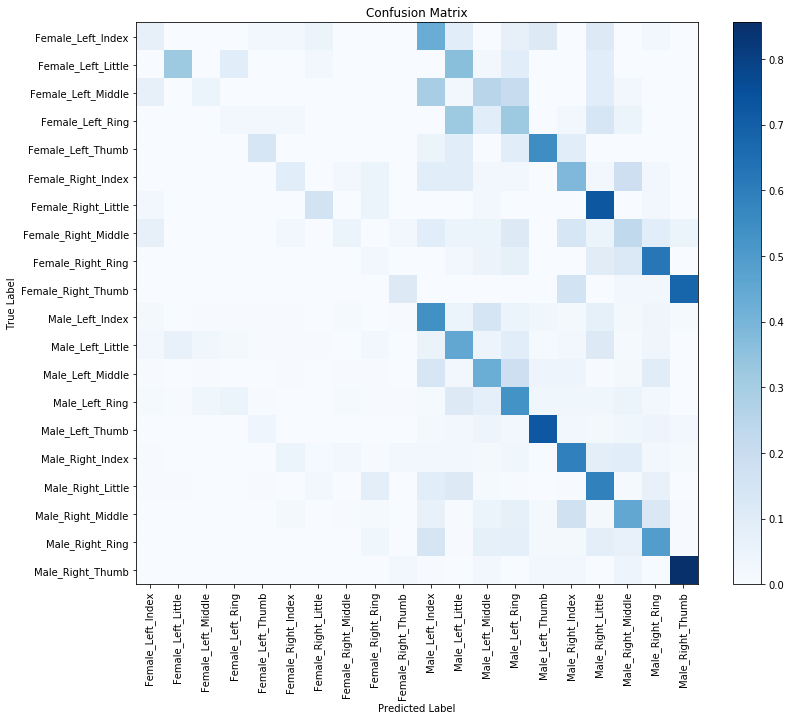

In [29]:
def plot_confusion_matrix(cm, classes, normalize=True, cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype("float") / (cm.sum(axis=1)[:, np.newaxis] + 1e-9)
    plt.figure(figsize=(12,10))
    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title("Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.tight_layout()

cm = confusion_matrix(test_y, y_pred)
plot_confusion_matrix(cm, classes)
plt.show()
